# Setup

#### Imports

In [1]:
import numpy as np
import pandas as pd
import sys
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

#### Parameters

In [2]:
# set default figure size:
plt.rcParams['figure.figsize'] = [15, 15]

In [3]:
W = 8
L = 8
Direction = 12

# Class Hierarchy

### State

The State class is instantiated for each possible state on the grid, represented by an (x,y) coordinate and a direction from 0 to 11.

In [4]:
class State:
    
    ## Constructor
    
    def __init__(self, x, y, direction):
        self.x = x
        self.y = y
        self.direction = direction
        
    ## Basic Getters/Setters
        
    def getX(self):
        return self.x
    
    def getY(self):
        return self.y
    
    def getDirection(self):
        return self.direction
    
    ## Formatted Getters/Setters (returns in different representation)
    
    def getCardinalDirection(self):
        return {0:0, 1:0, 2:1, 3:1, 4:1, 5:2, 6:2, 7:2, 8:3, 9:3, 10:3, 11:0}[self.direction]
    
    def getDirectionDegrees(self):
        return -self.direction*30 + 90 # 90 degrees is North
    
    def toTuple(self):
        return (self.x, self.y, self.direction)

### State Space
The state space contains a list of possible state objects given a map's dimensions (L, W, and number of directions). This class also contains helper functions to calculate possible next states etc (which depend on the particular state space).

In [5]:
class StateSpace:
    
    ## Constructor 
    
    def __init__(self, L, W, num_directions):
        self.L = L
        self.W = W
        self.num_directions = num_directions
        self.states = [State(x, y, i) for x in range(L) for y in range(W) for i in range(num_directions)]
        self.states_tuple = [(x, y, i) for x in range(L) for y in range(W) for i in range(12)]
        
    ## Basic Getters/Setters
        
    def getL(self):
        return self.L
    
    def getW(self):
        return self.W
    
    def getNumDirections(self):
        return self.num_directions

    def getNs(self):
        return len(self.states)

    def getStates(self):
        # Returns State objects of all possible states
        return self.states
    
    def getIndex(self, s):
        return self.getStatesTuple().index(s)
    
    ## Formatted Getters/Setters (returns in different representation)
    
    def getStatesTuple(self):
        # Returns all possible states, represented as tuples (x, y, direction)
        return self.states_tuple
    
    ## Helper Functions
                    
    def moveAndRotate(self, state, action):
        # Input: current state and an action to take
        # Output: tuple representing state after action is taken
        
        movement = action.getMovement()
        rotation = action.getRotation()
        
        if (movement == 0): # no movement, stay in the exact same state
            return state.toTuple()
        else: # up or down movement
            caridinal_dir = state.getCardinalDirection() # 0, 1, 2, 3 as up, right, down, left
            
            # calculate the absolute dx and dy based on cardinal direction and relative movement
            
            dx = 1 if \
                    ((caridinal_dir==1 and movement==1) or (caridinal_dir==3 and movement==-1)) \
                else -1 if \
                    ((caridinal_dir==1 and movement==-1) or (caridinal_dir==3 and movement==1)) \
                else 0
            dy = 1 if \
                    ((caridinal_dir==0 and movement==1) or (caridinal_dir==2 and movement==-1)) \
                else -1 if \
                    ((caridinal_dir==0 and movement==-1) or (caridinal_dir==2 and movement==1)) \
                else 0
            
            # Calculate x and y, and account for going out of the borders
            
            new_x = min(max(state.x+dx ,0), self.L-1)
            new_y = min(max(state.y+dy, 0), self.W-1)
            
            return (new_x, new_y, (state.getDirection() + rotation)%12)

    def getPossibleNextStates(self, pe, s, a):
        # Input: error probability, current state, action taken
        # Output: dictionary {(x, y, dir) tuple : probability} of all 3 possible outputs given randomness
        
        p_final_states = dict() # (x, y, dir) : probability
        p_prerotation = {-1: pe, 0: 1-2*pe, 1: pe}
        for prerotation in [-1, 0, 1]:
            random_state = State(s.getX(), s.getY(), (s.getDirection()+prerotation)%12)
            final_state = self.moveAndRotate(random_state, a)
            p_final_states[final_state] = p_prerotation[prerotation]
        return p_final_states
        
    def getPsa(self, pe, s, a, s_prime, verbose=False):
        # Input: error probability, current state, action taken, and the next state s_prime
        # Output: probability of being in s_prime, given the inputs
        
        possible_s_primes = self.getPossibleNextStates(pe, s, a) # dictionary of {state tuple: probability}

        s_prime_tuple = s_prime.toTuple()
        
        if (verbose):
            print(possible_s_primes)
        
        if (s_prime_tuple in possible_s_primes):
            return possible_s_primes[s_prime_tuple]
        else:
            return 0
    
    def getNextState(self, pe, s, a):
        # Input: error probability, current state, action
        # Output: next state, evaluated using actual randomness (sampling from the distribution)
        
        possible_s_primes = self.getPossibleNextStates(pe, s, a)
        state_tuples, probabilities = zip(*possible_s_primes.items())
        s_prime = state_tuples[np.random.choice(list(range(len(state_tuples))), 1, p=probabilities)[0]]
        return State(s_prime[0], s_prime[1], s_prime[2])
    
    def getEveryPossibleNextState(self, s):
        # Input: current state s 
        # Output: dictionary of all possible next states {state tuple: action} without accounting for randomness;
        #         note that we just look at all actions, and put the expected output state into the dictionary
        
        next_states = {}
        for a in ActionSpace().actions:
            next_state = self.moveAndRotate(s, a)
            if next_state not in next_states.keys():
                next_states[next_state] = a
        return next_states
    
    def getSPrimes(self, pe, s):
        # Input: current state
        # Output: dictionary where keys are actions and for every action we have an ARRAY of s primes associated
        
        s_primes_by_action = {}
        for a in ActionSpace().actions:
            next_states = self.getPossibleNextStates(pe, s, a)
            s_primes_by_action[a] = next_states
        return s_primes_by_action
            
    
    def getP(self, statespace, policy_matrix, pe):
        # Input: policy matrix, error probability
        # Output: matrix P (N_s x N_s), representing the probability of ending in state s_prime starting from s
        
        possible_states = statespace.getStatesTuple()
        P = np.zeros((statespace.getNs(), statespace.getNs()))
        for s in possible_states:
            s_index = statespace.getIndex(s)
            for possible_next_state, state_prob in statespace.getPossibleNextStates(pe, State(s[0], s[1], s[2]), policy_matrix[s_index]).items():
                s_prime_index = statespace.getIndex(possible_next_state)
                P[s_index][s_prime_index] = state_prob
        return P

### Action
The Action class is instantiated for each possible action (forward, backwards, staying the same; rotation -1, 0, or 1).

In [6]:
class Action:
    
    # Constructor
    
    def __init__(self, movement_dir, rotation_dir):
        # movement_dir = [-1, 0, 1], rotation_dir = [-1, 0, 1]
        self.movement_dir = movement_dir
        self.rotation_dir = rotation_dir
        
    # Basic Getters/Setters
    
    def getMovement(self):
        return self.movement_dir
    def getRotation(self):
        return self.rotation_dir
    
    # Formatted Getters/Setters
    
    def toTuple(self):
        return (self.movement_dir, self.rotation_dir)

### Action Space
The action space contains an every possible action that can be performed.

In [7]:
class ActionSpace:
    
    # Constructor
    
    def __init__(self):
        self.actions = [Action(movement_dir, rotation_dir) for movement_dir in [-1,1] for rotation_dir in [-1, 0, 1]] + [Action(0, 0)] 
        
    # Getters/Setters
        
    def getActions(self):
        return self.actions
    def getNa(self):
        return len(self.actions)

### Reward
The Reward class is used to represent and format the rewards for each state, and to pretty print it.

In [8]:
class Reward:
    
    # Constructor
    
    def __init__(self, W, L, goal_coords, is_yellow_func):
        # grid dimensions W and L, goal coordinates (x,y), and function returning True if reward=-10 (yellow)
        self.W = W
        self.L = L
        (self.goal_x, self.goal_y) = goal_coords
        self.is_yellow_func = is_yellow_func
        
    # Getters/Setters
    
    def getW(self):
        return self.W
    
    def getL(self):
        return self.L
    
    def getGoalCoords(self):
        return (self.goal_x, self.goal_y)
        
    # Helper Functions
        
    def getReward(self, s):
        # Input: current state s
        # Output: reward value for current state
        if (s.getX() == self.L-1 or s.getX() == 0 or s.getY() == self.W-1 or s.getY()==0):
            return -100
        elif (self.is_yellow_func(s)):
            return -10
        elif (s.getX() == self.goal_x and s.getY() == self.goal_y):
            return 1
        else:
            return 0
        
    def prettyPrint(self):
        return pd.DataFrame([[self.getReward(State(x,y,0)) for x in range(self.L)] for y in range(self.W)])

# Problem 1

### 1(a). Create (in code) your state space S = {s}. What is the size of the state space NS?

The state space is defined at the top of the document, in the "Classes" section; it is based on the variables L (length), W (width), and the 12 possible orientations of the robot.

Ns = L * W * 12

In this case, we evaluated using the given 8x8 grid (L=8, W=8).

In [9]:
statespace = StateSpace(L,W,Direction) # 8 x 8 x 12

statespace.getNs()

768

### 1(b). Create (in code) your action space A = {a}. What is the size of the action space NA?

The action space class is defined at the top of the document, in the "Classes" section.

The size of the action space is 7: three rotations each for forward and backward movement, and one extra action for staying put (no rotation possible).

In [10]:
actionspace = ActionSpace()
actionspace.getNa()

7

### 1(c). Write a function that returns the probability psa(s') given inputs pe, s, a, s'.

The function "getPsa" is tested below using an 8x8 grid, starting facing up at (2,2) and moving down and turning clockwise. There is a 20% error probability, so we expect to see 3 possible directions at the same location (one at direction 0, one at 1, and one at 2).

If we look at the probability of our error-free output (2,1,1), we should see that it has 60% probability, while the other two possible error states are each 20%.

In [11]:
pe = 0.2
start_state = State(2, 2, 0)
action_taken = Action(-1, 1)
final_state_to_evaluate = State(2,1,1)

statespace.getPsa(pe, start_state, action_taken, final_state_to_evaluate, verbose = True)

{(2, 1, 0): 0.2, (2, 1, 1): 0.6, (2, 1, 2): 0.2}


0.6

### 1(d). Write a function that uses the above to return a next state s' given error probability pe, initial state s, and action a. Make sure the returned value s' follows the probability distribution specified by psa.


The function "getNextState" uses the same helper function to calculate possible next states as getPsa() from question 1c. In this case, we evaluate 10000 random trials and see whether the distribution follows the distribution from 1c: {(2, 1, 0): 0.2, (2, 1, 1): 0.6, (2, 1, 2): 0.2}.

In [12]:
num_trials = 10000
trials = [y for y in [statespace.getNextState(pe, start_state, action_taken).toTuple() for x in range(num_trials)]]
for state_tuple in [(2,1,0), (2,1,1), (2,1,2)]:
    probability = len([x for x in trials if x == state_tuple])/num_trials
    print("Experimental probability of "+str(state_tuple)+" is "+str(probability))

Experimental probability of (2, 1, 0) is 0.2043
Experimental probability of (2, 1, 1) is 0.5939
Experimental probability of (2, 1, 2) is 0.2018


# Problem 2

### 2(a). Write a function that returns the reward R(s) given input s.
The Reward class is defined at the top of the document, in the "Classes" section. The reward matrix is shown below visiually. The function is then shown evaluated at a specific state.

In [13]:
reward_obj = Reward(W, L, (5,6), lambda s: s.getX()==3 and s.getY()>=4)
rewards = reward_obj.prettyPrint()

rewards

,0,1,2,3,4,5,6,7
0,-100,-100,-100,-100,-100,-100,-100,-100
1,-100,0,0,0,0,0,0,-100
2,-100,0,0,0,0,0,0,-100
3,-100,0,0,0,0,0,0,-100
4,-100,0,0,-10,0,0,0,-100
5,-100,0,0,-10,0,0,0,-100
6,-100,0,0,-10,0,1,0,-100
7,-100,-100,-100,-100,-100,-100,-100,-100


In [14]:
test_state = State(5,6, 0)

reward_obj.getReward(test_state)

1

# Problem 3

### 3(a). Create and populate a matrix/array that stores the action a = π0(s) prescribed by the initial policy π0 when indexed by state s.

In [15]:
def getBestAction(state, goal):
    # Input: current state, goal coordinates represented as (x,y)
    # Output: best action (represented by an Action object) to take based on initial policy
    
    cardinal_direction = state.getCardinalDirection()
    
    # Variables storing the final prescribed movement/rotation direction
    movement_direction = 0
    rotation_direction = 0
        
    # Facing up
    if (cardinal_direction == 0):
        if (state.getY() > goal[1]):
            movement_direction = -1
        elif (state.getY() < goal[1]):
            movement_direction = 1
        else:
            if (state.getX() != goal[0]):
                movement_direction = 1
        if (state.getX() < goal[0]):
            rotation_direction = 1
        elif (state.getX() > goal[0]):
            rotation_direction = -1
            
    # Facing Right      
    elif (cardinal_direction == 1):
        if (state.getX() > goal[0]):
            movement_direction = -1
        elif (state.getX() < goal[0]):
            movement_direction = 1
        else:
            if (state.getY() != goal[1]):
                movement_direction = 1
        if (state.getY() < goal[1]):
            rotation_direction = -1
        elif (state.getY() > goal[1]):
            rotation_direction = 1

    # Facing Down
    elif (cardinal_direction == 2):
        if (state.getY() > goal[1]):
            movement_direction = 1
        elif (state.getY() < goal[1]):
            movement_direction = -1
        else:
            if (state.getX() != goal[0]):
                movement_direction = 1
        if (state.getX() < goal[0]):
            rotation_direction = -1
        elif (state.getX() > goal[0]):
            rotation_direction = 1
       
    # Facing Left
    elif (cardinal_direction == 3):
        if (state.getX() > goal[0]):
            movement_direction = 1
        elif (state.getX() < goal[0]):
            movement_direction = -1
        else:
            if (state.getY() != goal[1]):
                movement_direction = 1
        if (state.getY() < goal[1]):
            rotation_direction = 1
        elif (state.getY() > goal[1]):
            rotation_direction = -1
    
    return Action(movement_direction, rotation_direction)

In [16]:
def getInitialPolicyMatrix(statespace, goal):
    # Input: goal coordinates (x,y)
    # Output: matrix, represented by a 3D array of (x,y direction);
    #         each element has an action as prescribed by the initial policy
    
    global W, L, Direction
    policy_matrix = [getBestAction(s, goal) for s in statespace.getStates()]
    return policy_matrix
#     policy_matrix = [[[getBestAction(State(x, y, direction), goal) for direction in range(Direction)] for y in range(L)] for x in range(W)]
#     return policy_matrix

def getNullPolicyMatrix(statespace):
    return [None for s in statespace.getStates()]
#     return [[[None for direction in range(Direction)] for y in range(L)] for x in range(W)]

Here, we use the functions defined above and test the initial policy evaluated at coordinate (0,0) for each of the 12 possible directions:

In [17]:
goal = reward_obj.getGoalCoords() # (5, 6)

p0_policy_matrix = getInitialPolicyMatrix(statespace=statespace, goal=goal)

targetX = 0
targetY = 0
for ind, a in enumerate(p0_policy_matrix):
    associated_s = statespace.getStates()[ind]
    if associated_s.getX() == targetX and associated_s.getY() == targetY:
        print('loc: ({},{}),\tdir: {}, \taction: {}'.format(targetX, targetY, associated_s.getDirection(), a.toTuple()))
# print([x.toTuple() for x in p0_policy_matrix[0][0]])

loc: (0,0),	dir: 0, 	action: (1, 1)
loc: (0,0),	dir: 1, 	action: (1, 1)
loc: (0,0),	dir: 2, 	action: (1, -1)
loc: (0,0),	dir: 3, 	action: (1, -1)
loc: (0,0),	dir: 4, 	action: (1, -1)
loc: (0,0),	dir: 5, 	action: (-1, -1)
loc: (0,0),	dir: 6, 	action: (-1, -1)
loc: (0,0),	dir: 7, 	action: (-1, -1)
loc: (0,0),	dir: 8, 	action: (-1, 1)
loc: (0,0),	dir: 9, 	action: (-1, 1)
loc: (0,0),	dir: 10, 	action: (-1, 1)
loc: (0,0),	dir: 11, 	action: (1, 1)


### 3(b). Write a function to generate and plot a trajectory of a robot given policy matrix/array π, initial state s0, and error probability pe.

In [18]:
def getTrajectory(num_steps, state_space, policy_matrix, s0, pe):
    # Inputs: # steps, state space, current policy matrix, start state, error probability
    # Outputs: list of tuples (x, y, direction) in the order that the policy prescribes
    
    current_state = s0
    trajectories = []
    
    for i in range(num_steps):
        trajectories.append(current_state.toTuple())
        chosen_action = policy_matrix[state_space.getIndex(current_state.toTuple())]
#         chosen_action = policy_matrix[current_state.getX()][current_state.getY()][current_state.getDirection()]
        current_state = state_space.getNextState(pe, current_state, chosen_action)
    return trajectories

In [19]:
initial_state = State(1,1,0)

trajectories = getTrajectory(20, statespace, p0_policy_matrix, initial_state, 0)
for state_tuple in trajectories:
    print(state_tuple)

(1, 1, 0)
(1, 2, 1)
(1, 3, 2)
(2, 3, 1)
(2, 4, 2)
(3, 4, 1)
(3, 5, 2)
(4, 5, 1)
(4, 6, 2)
(5, 6, 2)
(5, 6, 2)
(5, 6, 2)
(5, 6, 2)
(5, 6, 2)
(5, 6, 2)
(5, 6, 2)
(5, 6, 2)
(5, 6, 2)
(5, 6, 2)
(5, 6, 2)


In [20]:
def plotTrajectory(trajectories, rewards_np, border=0.5, grid_linewidth=0.5, colormap=None, saveto=None):
    # Input: trajectories array [(x, y, dir)], rewards as a numpy array, and other visualization parameters
    # Output: visualization of trajectory
    
    if colormap is None:
        colormap = {-100: 'red', -10: 'orange', 0: 'w', 1: 'g'}
    
    fig, ax = plt.subplots()
    
    grid_width = rewards_np.shape[0]
    grid_height = rewards_np.shape[1]
    
    total_width = grid_width + 2*border
    total_height = grid_height + 2*border
    
    # Draw the grid lines:
    for x in range(grid_width+1):
        ax.axhline(y=x-border, xmin=border/total_width, 
                   xmax=(grid_width+border)/total_width, linewidth=grid_linewidth, color='black')
    for y in range(grid_height+1):
        ax.axvline(x=y-border, ymin=border/total_height, 
                   ymax=(grid_height+border)/total_width, linewidth=grid_linewidth, color='black')
        
    # Draw the reward squares:
    for y in range(rewards.shape[1]):
        for x in range(rewards.shape[0]):
            ax.add_patch(Rectangle((x - border, y - border), 1, 1, alpha=0.7, color=colormap[rewards[x][y]]))
            
    # Draw the reward numbers in the bottom right corner:
    for y in range(rewards.shape[1]):
        for x in range(rewards.shape[0]):
            ax.text(x - border+1, y - border, "{} ".format(rewards[x][y]), va='bottom', ha='right')
    
    # Draw the trajectories    
    for i, trajectory in enumerate(trajectories):
        degree = State(trajectory[0], trajectory[1], trajectory[2]).getDirectionDegrees()
        
        bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="cyan", ec="b", lw=1, alpha=0.95)
        ax.text(trajectory[0], trajectory[1], "  {}  ".format(i), rotation=degree, bbox=bbox_props, va='center', ha='center')

    ax.set_aspect('equal')
    plt.xlim([-border*2, grid_width])
    plt.ylim([-border*2, grid_height])
    
    if saveto is not None:
        plt.savefig(saveto)
    
    plt.show()

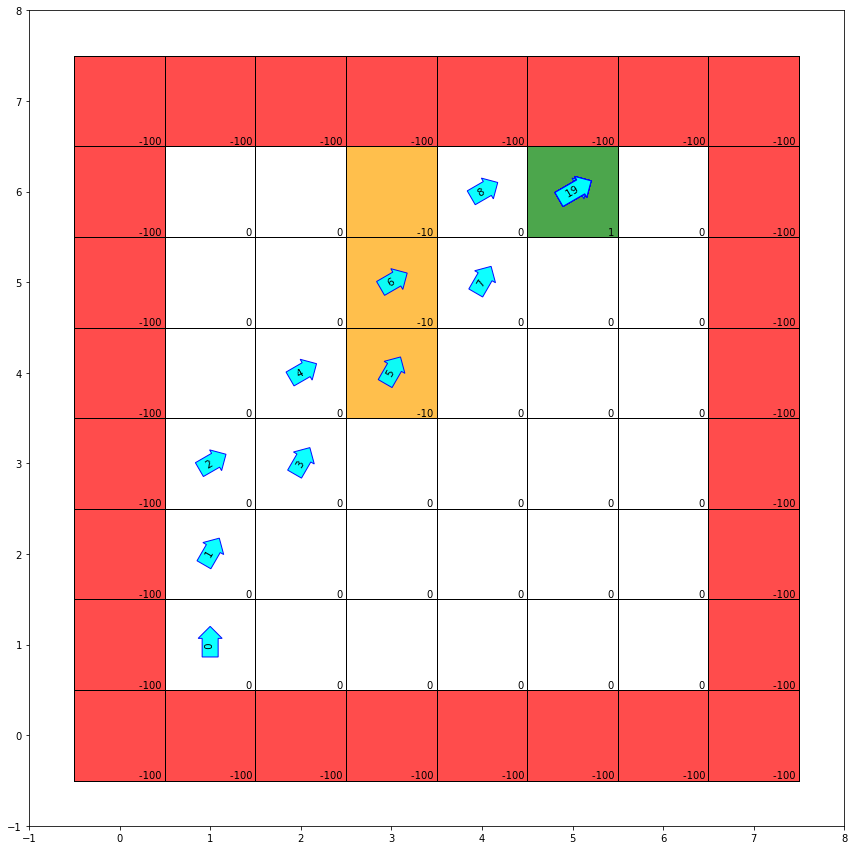

In [21]:
plotTrajectory(trajectories, rewards.values, border=0.5, grid_linewidth=1, colormap=None, saveto='trajectory.png')

### 3(c). Generate and plot a trajectory of a robot using policy π0 starting in state x = 1, y = 6, h = 6 (i.e. top left corner, pointing down). Assume pe = 0.

In [22]:
initial_state = State(1,6,6)

trajectories = getTrajectory(20, statespace, p0_policy_matrix, initial_state, 0)
for state_tuple in trajectories:
    print(state_tuple)

(1, 6, 6)
(1, 5, 5)
(1, 6, 4)
(2, 6, 4)
(3, 6, 4)
(4, 6, 4)
(5, 6, 4)
(5, 6, 4)
(5, 6, 4)
(5, 6, 4)
(5, 6, 4)
(5, 6, 4)
(5, 6, 4)
(5, 6, 4)
(5, 6, 4)
(5, 6, 4)
(5, 6, 4)
(5, 6, 4)
(5, 6, 4)
(5, 6, 4)


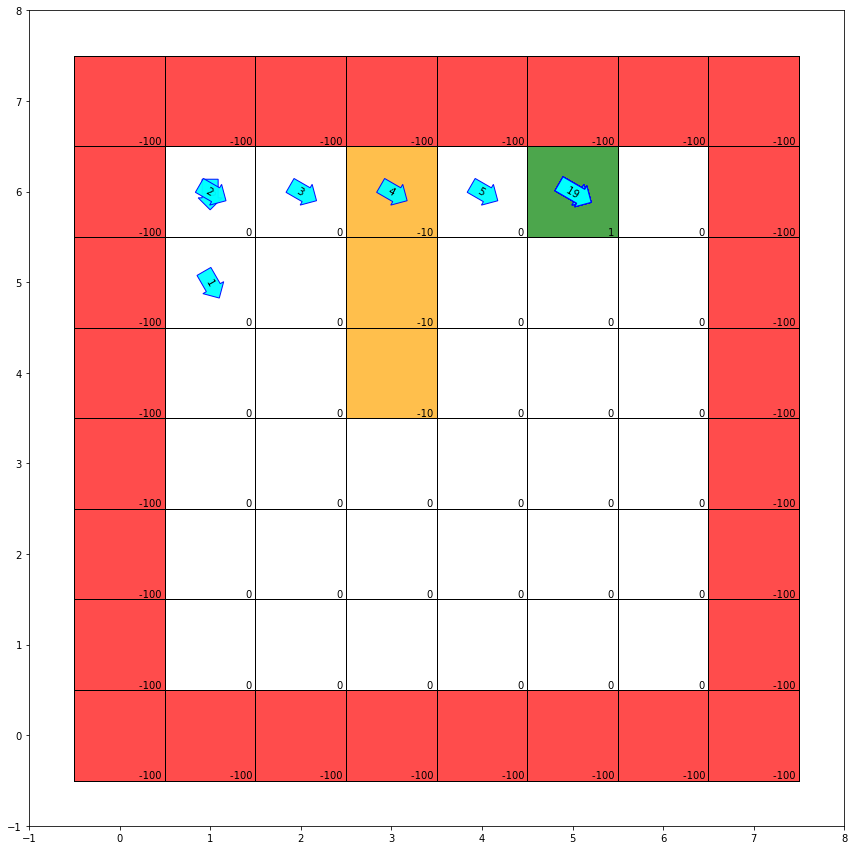

In [23]:
plotTrajectory(trajectories, rewards.values, border=0.5, grid_linewidth=1, colormap=None, saveto='trajectory.png')

### 3(d). Write a function to compute the policy evaluation of a policy π. That is, this function should return a matrix/array of values v = Vπ(s) when indexed by state s. The inputs will be a matrix/array storing π as above, along with discount factor λ.

In [24]:
# compute R, which has reward for each state in statespace
R = np.array([rewards[t[0]][t[1]] for t in statespace.getStatesTuple()])

def policyEval(pi, discount, pe=0):
    # Input: policy matrix and discount factor
    # Output: numpy array V, value (length = Ns, one value per state)
    
    global R, statespace

    max_delta = 0.00001
    delta = 1
    
    # convert policy matrix to probabilities P of ending up in each state s starting from s_prime (Ns x Ns)
    P = statespace.getP(statespace, pi, pe)

    V = np.zeros((statespace.getNs()))
    
    while (delta > max_delta):
        V_new = R + np.dot(P, discount*V)
        delta = np.sum(np.abs(V-V_new))
        V = V_new
    
    return V

v_k = policyEval(p0_policy_matrix, discount=0, pe=0.2)

In [25]:
def visualizeValues(v, direction=0):
    
    # Convert v into a dictionary {(x,y): value}
    values = {(state_tuple[0], state_tuple[1]):v[i] for i, state_tuple in enumerate(statespace.getStatesTuple()) if state_tuple[2] == direction}
    
    # Convert dictionary to numpy array
    values_np = np.zeros((statespace.getL(),statespace.getW()))
    for x_y in values:
        values_np[x_y[0]][x_y[1]] = values[x_y]
        
    # Convert numpy array to dataframe for visualization
    return pd.DataFrame([[round(values_np[x][y],1) for x in range(statespace.getL())] for y in range(statespace.getW())])

visualizeValues(v_k, direction=1)

,0,1,2,3,4,5,6,7
0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
1,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,-100.0
2,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,-100.0
3,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,-100.0
4,-100.0,0.0,0.0,-10.0,0.0,0.0,0.0,-100.0
5,-100.0,0.0,0.0,-10.0,0.0,0.0,0.0,-100.0
6,-100.0,0.0,0.0,-10.0,0.0,1.0,0.0,-100.0
7,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0


Here, we tested the output using our initial policy matrix with no discount. We evaluated at each location with direction of 1 and error probability of 0.2, which is why we see many locations with -20 and -80 values.

### 3(e). What is the value of the trajectory in 3(c)? Use λ = 0.9.

In [26]:
v_k = policyEval(p0_policy_matrix, discount=0.9, pe=0)
visualizeValues(v_k, direction=4)

,0,1,2,3,4,5,6,7
0,-340.8,-340.4,-340.0,-340.4,-340.0,-340.4,-340.0,-340.4
1,-96.5,3.9,4.3,3.9,4.3,3.9,4.3,-96.1
2,-96.1,4.3,4.8,4.3,4.8,4.3,4.8,-95.7
3,-102.3,4.8,5.3,4.8,5.3,4.8,5.3,-95.2
4,-109.1,-2.8,-3.1,-189.3,5.9,-179.3,5.9,-279.3
5,-108.5,-2.2,-2.4,-64.3,6.6,-54.3,6.6,-154.3
6,-101.4,-1.5,-1.7,-1.9,9.0,10.0,9.0,-91.9
7,-191.2,-191.4,-191.5,-182.7,-181.9,-184.1,-181.9,-184.1


In [27]:
trajectories = getTrajectory(10, statespace, p0_policy_matrix, initial_state, 0)
for state_tuple in trajectories:
    print(state_tuple)

(1, 6, 6)
(1, 5, 5)
(1, 6, 4)
(2, 6, 4)
(3, 6, 4)
(4, 6, 4)
(5, 6, 4)
(5, 6, 4)
(5, 6, 4)
(5, 6, 4)


In [28]:
def trajectoryValues(trajectories, V, discount, verbose=False):
    trajectory_values = []
    previous_value = None
    previous_state = None
    value_sum = 0
    for i, chosen_state in enumerate(trajectories):
        if previous_state is not None and chosen_state == previous_state:
            break
        
        # get value of current state
        chosen_state_index = statespace.getStatesTuple().index(chosen_state)
        current_value = V[chosen_state_index]
        value_sum += current_value * (discount**i)
        if verbose:
            print("Adding value "+str(current_value)+" at state "+str(chosen_state))

        # stop when value doesn't change
        if previous_value is not None:
            if current_value - previous_value == 0:
                break

        previous_value = current_value
        trajectory_values.append(current_value)
        
        previous_state = chosen_state
        
    return trajectory_values, value_sum

In [29]:
trajectory_values, value_sum = trajectoryValues(trajectories, v_k, discount=0.9)

print('Value of trajectory: {}'.format(value_sum))

Value of trajectory: 4.395869430334332


###  3(f). Write a function that returns a matrix/array π giving the optimal policy given a one-step lookahead on value V.

In [30]:
def policyRefinement(v_pi, pe):
    # Input: values for each state
    # Output: next policy (3D array with an action at each element)
    
    # Create empty list for new policy
    new_policy = getNullPolicyMatrix(statespace)
    
    # Iterate through each state and find optimal action
    for s_index, s in enumerate(statespace.getStates()):
        
        best_action = None
        best_value = None
        
        # iterate through each action
        for action in actionspace.getActions():
            action_value = 0
            
            possible_next_states = statespace.getPossibleNextStates(pe, s, action) # dictionary {state tuple: prob}
            for possible_state in possible_next_states:
                prob = possible_next_states[possible_state]
                possible_state_index = statespace.getIndex(possible_state)
                action_value += prob * v_pi[possible_state_index]

            if (best_value is None or action_value >= best_value):
                best_value = action_value
                best_action = action
                    
        new_policy[s_index] = best_action
    
    return new_policy

### 3(g). Combine your functions above in a new function that computes policy iteration on the system, returning optimal policy π∗ with optimal value V ∗.

In [31]:
def policyIteration(p0_policy, discount, pe, verbose=False):
    
    current_policy_matrix = p0_policy
    
    iteration_no = 1
    is_converged = False
        
    while not is_converged:
        if verbose:
            print("starting iteration "+str(iteration_no))
    
        # given a value function V^pi
        v = policyEval(current_policy_matrix, discount=discount, pe=pe)

        next_policy_matrix = policyRefinement(v, pe)

        if verbose:
            print("Policy matrix BEFORE iteration "+str(iteration_no))
            print("-----")
            print(pd.DataFrame([[current_policy_matrix[statespace.getIndex(State(x, y, 0).toTuple())].toTuple() for x in range(8)] for y in range(8)]))
            print("-----")
        
            values = {(state_tuple[0], state_tuple[1]):v[i] for i, state_tuple in enumerate(statespace.getStatesTuple()) if state_tuple[2] == 0}
            values_np = np.zeros((8,8))
            for x_y in values:
                values_np[x_y[0]][x_y[1]] = values[x_y]
            print("Value matrix for dir=0 iteration "+str(iteration_no))
            print("-----")
            print(pd.DataFrame([[round(values_np[x][y],1) for x in range(8)] for y in range(8)]))
            print("-----")
        
            values = {(state_tuple[0], state_tuple[1]):v[i] for i, state_tuple in enumerate(statespace.getStatesTuple()) if state_tuple[2] == 1}
            values_np = np.zeros((8,8))
            for x_y in values:
                values_np[x_y[0]][x_y[1]] = values[x_y]
            print("Value matrix for dir=1 iteration "+str(iteration_no))
            print("-----")
            print(pd.DataFrame([[round(values_np[x][y],1) for x in range(8)] for y in range(8)]))
            print("-----")
        
            values = {(state_tuple[0], state_tuple[1]):v[i] for i, state_tuple in enumerate(statespace.getStatesTuple()) if state_tuple[2] == 11}
            values_np = np.zeros((8,8))
            for x_y in values:
                values_np[x_y[0]][x_y[1]] = values[x_y]
            print("Value matrix for dir=11 iteration "+str(iteration_no))
            print("-----")
            print(pd.DataFrame([[round(values_np[x][y],1) for x in range(8)] for y in range(8)]))
            print("-----")

            print("Policy matrix AFTER iteration "+str(iteration_no))
            print("-----")
            print(pd.DataFrame([[next_policy_matrix[statespace.getIndex(State(x, y, 0).toTuple())].toTuple() for x in range(8)] for y in range(8)]))
            print("-----")
        
        is_converged_current = True
        for i, action in enumerate(current_policy_matrix):
            if (action.toTuple()!=next_policy_matrix[i].toTuple()):
                is_converged_current = False
        if (is_converged_current):
            is_converged=True

        current_policy_matrix = next_policy_matrix
        
        iteration_no += 1
        
        if (iteration_no ==20):
            break
        
    V = policyEval(current_policy_matrix, discount=discount, pe=pe)
    return current_policy_matrix, V

start = time.time()
optimal_policy_matrix, v_k = policyIteration(p0_policy_matrix, discount=0.9, pe=0)
print("Time taken: "+str(time.time()-start))

Time taken: 2.1814827919006348


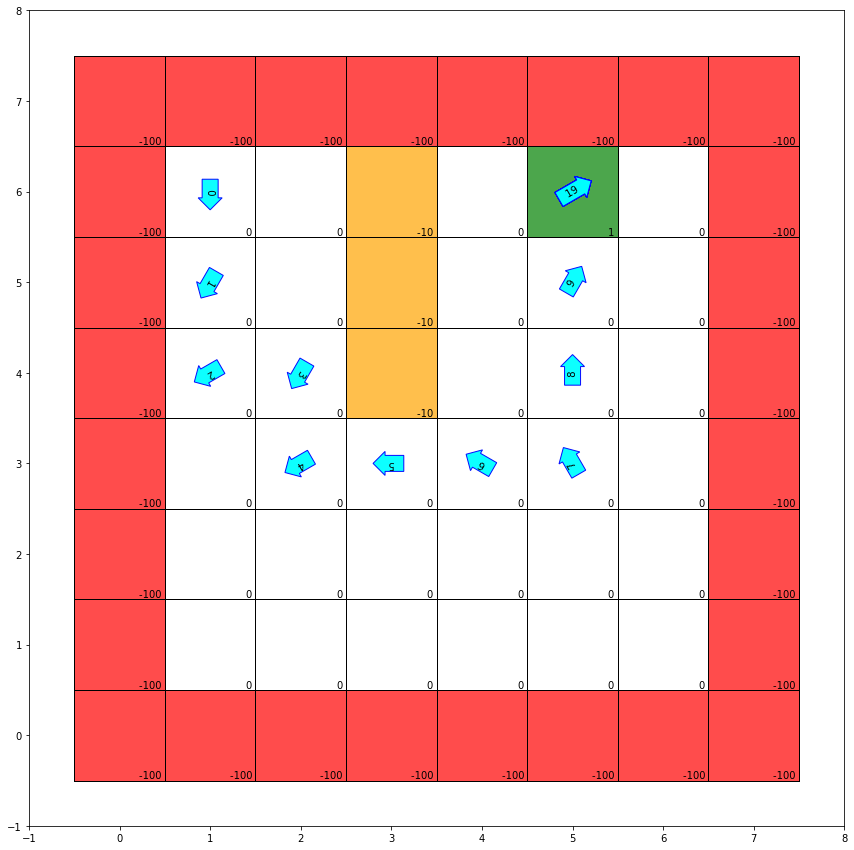

In [32]:
trajectories2 = getTrajectory(20, statespace, optimal_policy_matrix, State(1,6,6), 0)
plotTrajectory(trajectories2, rewards.values, border=0.5, grid_linewidth=1, colormap=None, saveto='trajectory.png')

### 3(h). Run this function to recompute and plot the trajectory and value of the robot described in 3(c) under the optimal policy π∗.

In [33]:
trajectory_values, value_sum = trajectoryValues(trajectories2, v_k, discount=0.9, verbose=False)

print('Value of trajectory: {}'.format(value_sum))

Value of trajectory: 38.35462766172605


### 3(i). How much compute time did it take to generate your results from 3(h)? You may want to use your programming language’s built-in runtime analysis tool.

It took us 4.27 seconds to generate the results for 3(h)


# Problem 4

### 4(a). Using an initial condition V (s) = 0 ∀s ∈ S, write a function (and any necessary subfunctions) to compute value iteration, again returning optimal policy π ∗ with optimal value V ∗.

In [34]:
def best_policy_given_v(v_pi, statespace, pe):
    # Input: values for each state
    # Output: next policy (3D array with an action at each element)
    
    # Create empty list for new policy
    new_policy = getNullPolicyMatrix(statespace)
    
    # Iterate through each state and find optimal action
    for s_index, s in enumerate(statespace.getStates()):
        
        best_action = None
        best_value = None
        
        # iterate through each action
        for action in actionspace.getActions():
            action_value = 0
            
            possible_next_states = statespace.getPossibleNextStates(pe, s, action) # dictionary {state tuple: prob}
            for possible_state in possible_next_states:
                prob = possible_next_states[possible_state]
                possible_state_index = statespace.getIndex(possible_state)
                action_value += prob * v_pi[possible_state_index]
                
            if (best_value is None or action_value >= best_value):
                best_value = action_value
                best_action = action
                    
        new_policy[s_index] = best_action
    return new_policy

def valueRefinement(V, discount, pe, current_policy_matrix, is_problem_5=False):
    global statespace
        
    R = np.array([rewards[t[0]][t[1]] for t in statespace.getStatesTuple()])
    R2 = R.copy()
    for i in range(12):
        R2[statespace.getStatesTuple().index((5,6,i))] = 0
        
    # convert policy matrix to probabilities P of ending up in each state s starting from s_prime (Ns x Ns)
    P = statespace.getP(statespace, current_policy_matrix, pe)
    
    # Update value
    for s in tqdm(range(statespace.getNs())):
        V[s] =  sum([P[s,s1] * ((R2[s] if statespace.getStatesTuple()[s][2]!=6 and is_problem_5 else R[s]) + discount*V[s1]) for s1 in range(statespace.getNs())])

        
    # return the optimal policy:
    better_policy = best_policy_given_v(V, statespace, pe)
    
    return better_policy, V

In [35]:
def policiesMatch(policy1, policy2):
    for ind, p1 in enumerate(policy1):
        if p1.toTuple() != policy2[ind].toTuple():
            return False
    return True

def valueIteration(p0_policy_matrix, discount, pe, statespace, verbose=False, is_problem_5=False):
    V = np.zeros(statespace.getNs())
    
    v_converged = False
    iteration_no = 0
    current_policy_matrix = p0_policy_matrix
    
    while not v_converged:
        if (verbose):
            print("starting iteration "+str(iteration_no))
        
            print("Value matrix BEFORE iteration "+str(iteration_no))
            print("-----")
            print(pd.DataFrame([[round(V[statespace.getIndex((x,y,0))],1) for x in range(8)] for y in range(8)]))
            print("-----")
        
        next_best_policy, V = valueRefinement(V, discount, pe, current_policy_matrix, is_problem_5)
        
        if (verbose):
            print("Policy matrix AFTER iteration "+str(iteration_no))
            print("-----")
            print(pd.DataFrame([[next_best_policy[statespace.getIndex(State(x, y, 0).toTuple())].toTuple() for x in range(8)] for y in range(8)]))
            print("-----")

        v_converged = policiesMatch(current_policy_matrix, next_best_policy)
        current_policy_matrix = next_best_policy

        iteration_no += 1
        
    return current_policy_matrix, V

### 4(b). Run this function to recompute and plot the trajectory and value of the robot described in 3(c) under the optimal policy π ∗ . Compare these results with those you got from policy iteration in 3(h).

In [36]:
start = time.time()
optimal_policy_matrix, v_k = valueIteration(p0_policy_matrix, discount=0.9, pe=0, statespace=statespace)
print("Time taken: "+str(time.time()-start))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:02<00:00, 284.42it/s]


Time taken: 38.990445613861084


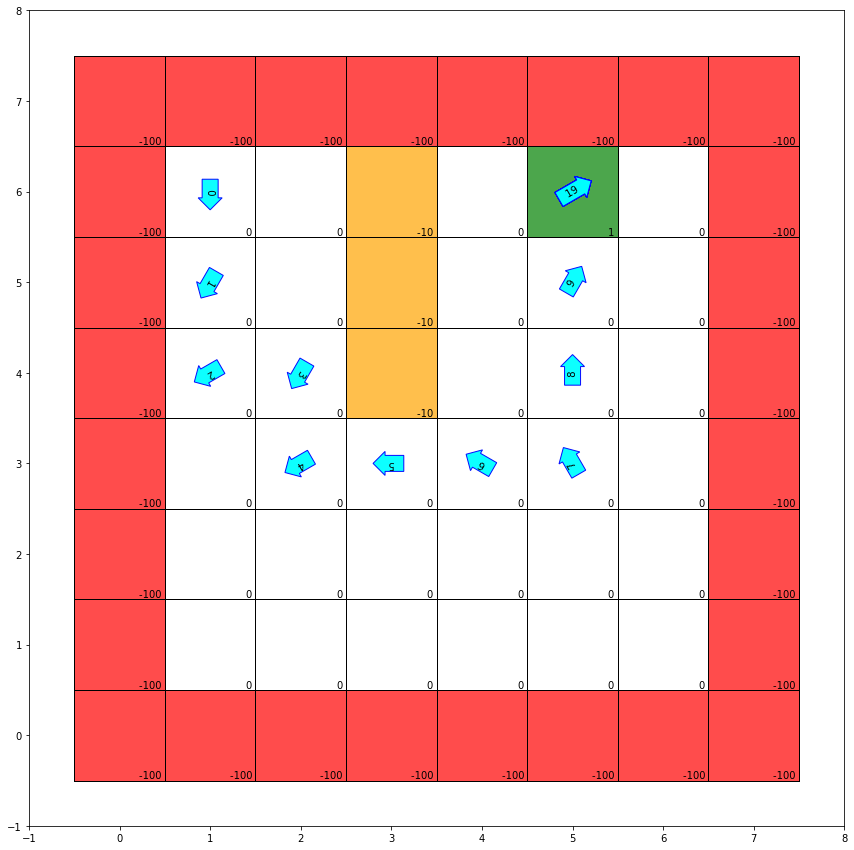

In [37]:
trajectories2 = getTrajectory(20, statespace, optimal_policy_matrix, State(1,6,6), 0)
plotTrajectory(trajectories2, rewards.values, border=0.5, grid_linewidth=1, colormap=None, saveto='trajectory.png')

In [38]:
trajectory_values, value_sum = trajectoryValues(trajectories2, v_k, discount=0.9, verbose=False)

print('Value of trajectory: {}'.format(value_sum))

Value of trajectory: 22.427312282498512


#### Comparing the results of policy iteration vs value iteration

Policy iteration converged significantly faster (4.27 seconds) than value iteration (63.87 seconds). Additionally, the value of the trajectory that policy iteration calculates for its trajectory is higher (38.35) than the value that value iteration calculates (22.43). However, despite these differences, the actual trajectories calculated by the two methods are the same. The difference in the runtimes of the two algorithms is caused by value iteration taking more steps, each with a smaller gain--compared to policy iteration which takes fewer steps, each with a larger gain. Thus, value iteration can be stopped before convergence and have a fairly accurate trajectory, while policy iteration is likely to be very far off before convergence. Consequently, it can be useful to combine the two iteration methods.

### 4(c). How much compute time did it take to generate your results from 4(b)? Use the same timing method as in 3(i).

It took 63.87 seconds to complete value iteration in 4(b). This is significantly longer than it took us to complete 3(h) (4.27 seconds). 

# 5 - Additional Scenarios

### 5(a). Recompute the robot trajectory and value given initial conditions from 3(c) but with pe = 25%.

#### Using Policy Iteration

In [39]:
start = time.time()
optimal_policy_matrix, V = policyIteration(p0_policy_matrix, discount=0.9, pe=0.25)
print("Time taken: "+str(time.time()-start))

Time taken: 2.141493558883667


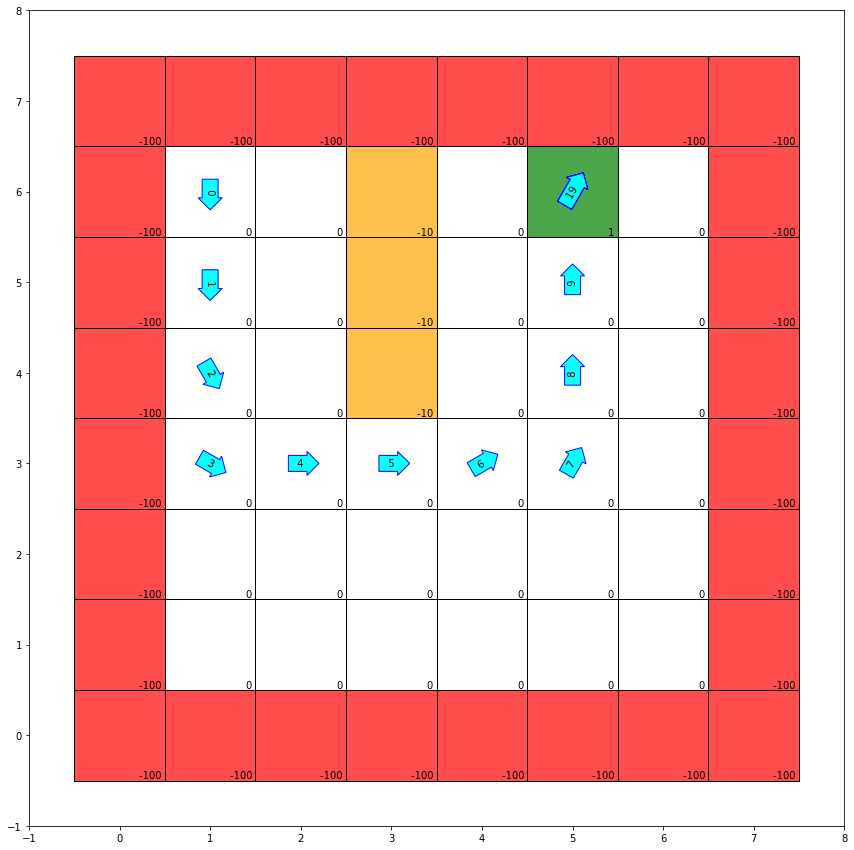

In [40]:
trajectories = getTrajectory(20, statespace, optimal_policy_matrix, State(1,6,6), 0)
plotTrajectory(trajectories, rewards.values, border=0.5, grid_linewidth=1, colormap=None, saveto='trajectory.png')

In [41]:
trajectory_values, value_sum = trajectoryValues(trajectories, V, discount=0.9, verbose=False)

print('Value of trajectory: {}'.format(value_sum))

Value of trajectory: 28.148267324347014


#### Using Value Iteration 

In [42]:
start = time.time()
optimal_policy_matrix, V = valueIteration(p0_policy_matrix, discount=0.9, pe=0.25, statespace=statespace)
print("Time taken: "+str(time.time()-start))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:02<00:00, 282.86it/s]


Time taken: 53.959614992141724


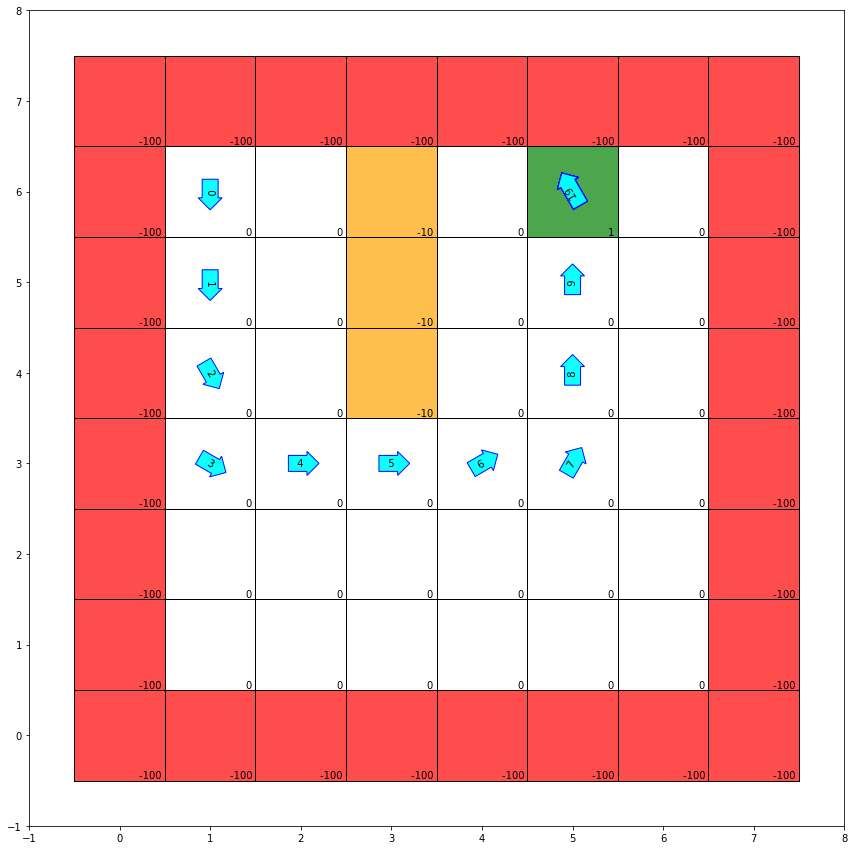

In [43]:
trajectories = getTrajectory(20, statespace, optimal_policy_matrix, State(1,6,6), 0)
plotTrajectory(trajectories, rewards.values, border=0.5, grid_linewidth=1, colormap=None, saveto='trajectory.png')

In [44]:
trajectory_values, value_sum = trajectoryValues(trajectories, V, discount=0.9, verbose=False)

print('Value of trajectory: {}'.format(value_sum))

Value of trajectory: 22.86017134552592


### 5(b). Assume the reward of +1 only applies when the robot is pointing straight down, e.g. h = 6 in the goal square; the reward is 0 otherwise. Recompute trajectories and values given initial conditions from 3(c) with pe ∈ {0, 25%}.

#### Using value iteration, pe = 0

In [45]:
start = time.time()
optimal_policy_matrix, V = valueIteration(p0_policy_matrix, discount=0.9, pe=0, statespace=statespace, is_problem_5=True)
print("Time taken: "+str(time.time()-start))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:02<00:00, 286.72it/s]


Time taken: 38.849584102630615


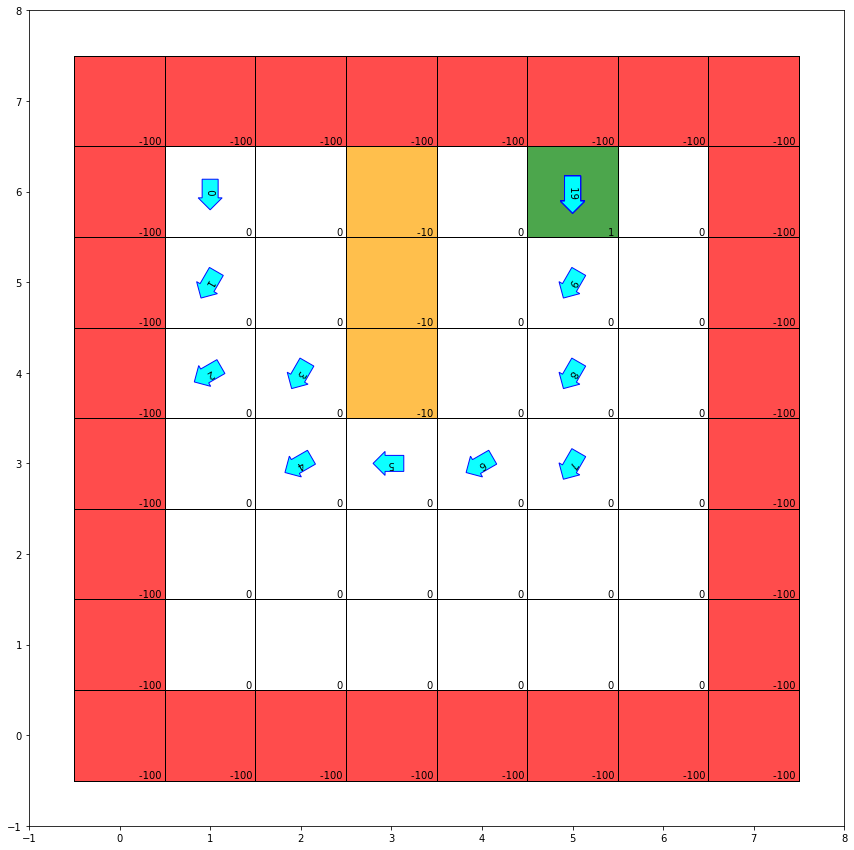

In [46]:
trajectories = getTrajectory(20, statespace, optimal_policy_matrix, State(1,6,6), 0)
plotTrajectory(trajectories, rewards.values, border=0.5, grid_linewidth=1, colormap=None, saveto='trajectory.png')

In [47]:
trajectory_values, value_sum = trajectoryValues(trajectories, V, discount=0.9, verbose=False)

print('Value of trajectory: {}'.format(value_sum))

Value of trajectory: 22.427312282498512


#### Using value iteraton, pe = 0.25

In [49]:
start = time.time()
optimal_policy_matrix, V = valueIteration(p0_policy_matrix, discount=0.9, pe=0.25, statespace=statespace, is_problem_5=True)
print("Time taken: "+str(time.time()-start))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:02<00:00, 286.93it/s]


Time taken: 80.11695051193237


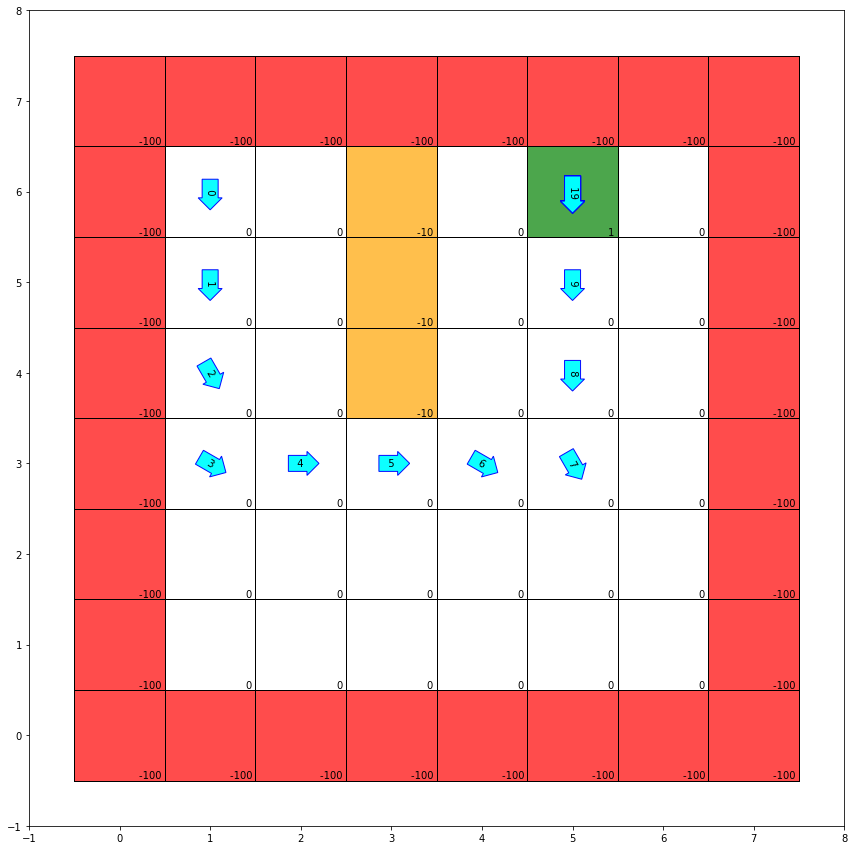

In [50]:
trajectories = getTrajectory(20, statespace, optimal_policy_matrix, State(1,6,6), 0)
plotTrajectory(trajectories, rewards.values, border=0.5, grid_linewidth=1, colormap=None, saveto='trajectory.png')

In [51]:
trajectory_values, value_sum = trajectoryValues(trajectories, V, discount=0.9, verbose=False)

print('Value of trajectory: {}'.format(value_sum))

Value of trajectory: 7.393915027646906


### 5(c). Qualitatively describe some conclusions from these scenarios.

For 5a, we saw that when we increased our error probability to 0.25 in each direction, we saw that it took a similar path compared to problem 4, except that we saw a much cleaner path that was much more focused than before. This makes sense because, due to the error probability, our robot wants to be in a state that will still get closer to the goal despite the likely errors. For example, facing directly up is the safest way to go up because even if we have an error to the right or left directions, we will still end up going up. In comparison, if we were at direction=1 and the error moved us clockwise, we would end up going right instead of going up (taking us further from the goal).

For 5b, we saw that when we gave a different reward criteria, we were able to choose a different path that still got to the optimal point in the same amount of time. This shows how by adjusting our hyperparameters and rewards, we are able to fine tune the specific path the robot takes to get to the goal (just like we were able to do by modifying the discount factor and error probability).

Policy iteration converged significantly faster (4.27 seconds) than value iteration (63.87 seconds). Additionally, the value of the trajectory that policy iteration calculates for its trajectory is higher (38.35) than the value that value iteration calculates (22.43). However, despite these differences, the actual trajectories calculated by the two methods are the same. The difference in the runtimes of the two algorithms is caused by value iteration taking more steps, each with a smaller gain--compared to policy iteration which takes fewer steps, each with a larger gain. Thus, value iteration can be stopped before convergence and have a fairly accurate trajectory, while policy iteration is likely to be very far off before convergence. Consequently, it can be useful to combine the two iteration methods.